# CO2 Emission by Vehicles

This dataset captures the details of how CO2 emissions by a vehicle can vary with the different features. The dataset has been taken from Canada Government official open data website. This is a compiled version. This contains data over a period of 7 years.
There are total 7385 rows and 12 columns. There are few abbreviations that has been used to describe the features. 


## The Data 

### Model

- 4WD/4X4 = Four-wheel drive
- AWD = All-wheel drive
- FFV = Flexible-fuel vehicle
- SWB = Short wheelbase
- LWB = Long wheelbase
- EWB = Extended wheelbase

### Transmission

- A = Automatic
- AM = Automated manual
- AS = Automatic with select shift
- AV = Continuously variable
- M = Manual
- 3 - 10 = Number of gears

### Fuel type

- X = Regular gasoline
- Z = Premium gasoline
- D = Diesel
- E = Ethanol (E85)
- N = Natural gas

### Fuel Consumption

City and highway fuel consumption ratings are shown in litres per 100 kilometres (L/100 km) - the combined rating (55% city, 45% hwy) is shown in L/100 km and in miles per gallon (mpg) CO2 Emissions

The tailpipe emissions of carbon dioxide (in grams per kilometre) for combined city and highway driving


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Get the data

In [2]:
emissions = pd.read_csv('CO2 Emissions_Canada.csv')

In [3]:
emissions.columns

Index(['Make', 'Model', 'Vehicle Class', 'Engine Size(L)', 'Cylinders',
       'Transmission', 'Fuel Type', 'Fuel Consumption City (L/100 km)',
       'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
       'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)'],
      dtype='object')

In [4]:
emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [5]:
emissions.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


## Handling missing data and possible data transformations
- Remove missing values, outliers, and unnecessary rows/ columns
- Check and impute null values
- Check Imbalanced data
- Re-indexing and reformatting our data

### 1. Missing Values

Make                                0
Model                               0
Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
dtype: int64

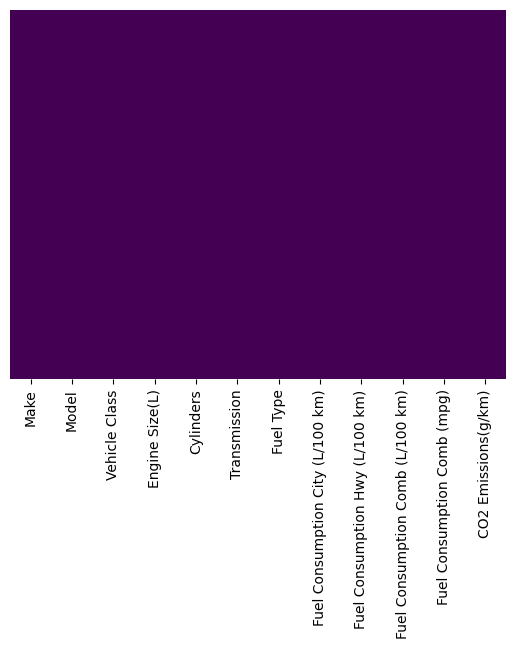

In [6]:
sns.heatmap(emissions.isnull(),yticklabels=False,cbar=False,cmap='viridis')
emissions.isnull().sum()

Assim, podemos concluir que não existem missing values neste dataset

## Handling Categorical Features

In [9]:
emissions['Make'].value_counts().count()

42

In [19]:
emissions['Model'].value_counts()

Model
F-150 FFV            32
F-150 FFV 4X4        32
MUSTANG              27
FOCUS FFV            24
SONIC 5              20
                     ..
Camry AWD LE/SE       1
Camry AWD XLE/XSE     1
Corolla XLE           1
Corolla XSE           1
Corolla Hybrid        1
Name: count, Length: 2053, dtype: int64

In [22]:
# the model has one of this is it 4WD/4X4, AWD, FFV, SWB, LWB, EWB. if it don't has any so None, if it has then it appears the tag
copy = emissions.copy()
# it has to substitute the ones that dont have tag with None
copy['Model'] = copy['Model'].apply(lambda x: x if '/' in x else 'None')
# copy['Model'].apply(lambda x: x.split(' ')[-1]).value_counts()
copy['Model'] = copy['Model'].apply(lambda x: x.split(' ')[-1])
copy['Model'].value_counts()


Model
None                7326
(Start/Stop)          12
XLE/SE                 7
LE/XLE                 4
Stop/Start)            4
XLE/XSE                4
LE/SE                  4
SR/Platinum            4
XL/XLT                 3
AWD                    3
SPORT/LIMITED          3
System)                3
Sport/Touring          2
SPORT/TOURING          1
Z/28                   1
Edition                1
EX/Touring             1
Limited/Platinum       1
Off-Road/Pro           1
Name: count, dtype: int64

In [10]:
emissions['Vehicle Class'].value_counts().count()

16

Vehicle Class
SUV - SMALL                 1217
MID-SIZE                    1133
COMPACT                     1022
SUV - STANDARD               735
FULL-SIZE                    639
SUBCOMPACT                   606
PICKUP TRUCK - STANDARD      538
TWO-SEATER                   460
MINICOMPACT                  326
STATION WAGON - SMALL        252
PICKUP TRUCK - SMALL         159
MINIVAN                       80
SPECIAL PURPOSE VEHICLE       77
VAN - PASSENGER               66
STATION WAGON - MID-SIZE      53
VAN - CARGO                   22
Name: count, dtype: int64


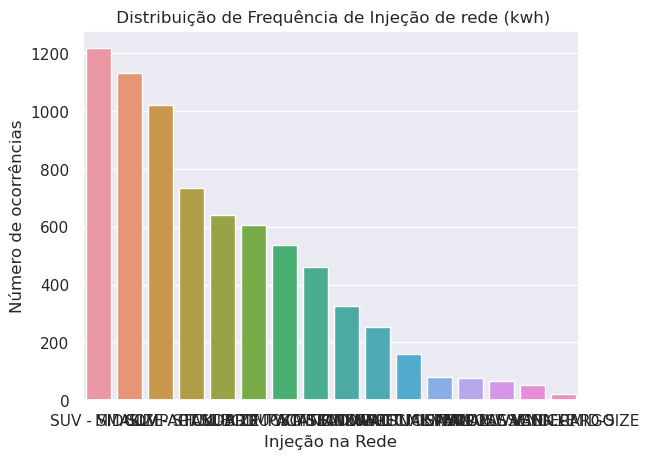

In [11]:
vehicle_class_count = emissions['Vehicle Class'].value_counts()
print(vehicle_class_count)
sns.set(style="darkgrid")
sns.barplot(x=vehicle_class_count.index, y=vehicle_class_count.values)
plt.title(' Distribuição de Frequência de Injeção de rede (kwh)')
plt.ylabel('Número de ocorrências', fontsize=12)
plt.xlabel('Injeção na Rede', fontsize=12)
plt.show()

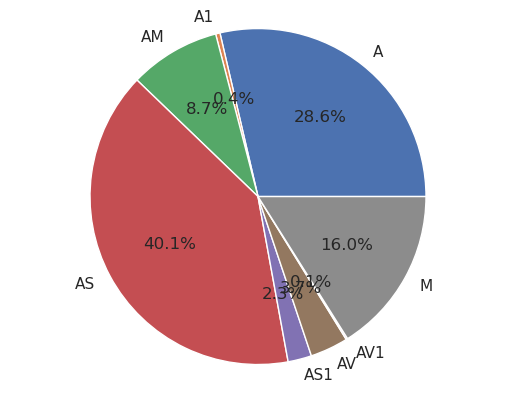

In [16]:
# transmission type is letters + one number, so take out the number
transmission_count = emissions['Transmission'].str[:-1]
labels = transmission_count.astype('category').cat.categories.tolist()
counts = transmission_count.value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.show()

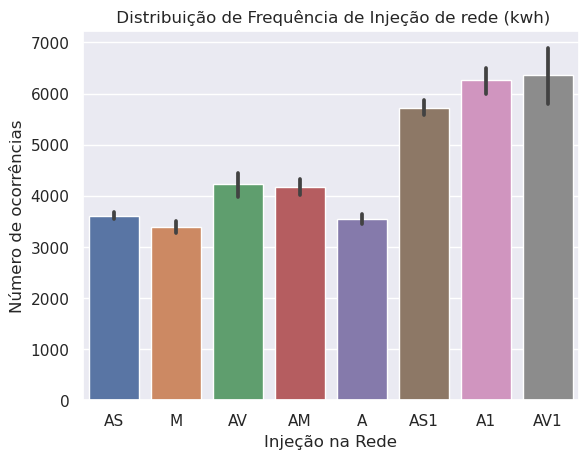

In [18]:
transmission_count = emissions['Transmission'].str[:-1]
sns.set(style="darkgrid")
sns.barplot(x=transmission_count.values, y=transmission_count.index)
plt.title(' Distribuição de Frequência de Injeção de rede (kwh)')
plt.ylabel('Número de ocorrências', fontsize=12)
plt.xlabel('Injeção na Rede', fontsize=12)
plt.show()